Please upload the Excel file '_TPS_30MINEVIDENCIA.xlsx'


Saving _TPS_30MINEVIDENCIA.xlsx to _TPS_30MINEVIDENCIA (1).xlsx
Uploaded file: _TPS_30MINEVIDENCIA (1).xlsx

First 5 rows of the data:
      1          Local Date  Close
0  1016 2025-06-02 02:10:00  77.39
1  1015 2025-06-02 02:15:00  77.61
2  1014 2025-06-02 03:15:00  78.27
3  1013 2025-06-02 03:20:00  78.27
4  1012 2025-06-02 03:45:00  78.19

Columns: [1, 'Local Date', 'Close']

First 5 rows of Close series:
Local Date
2025-06-02 02:10:00    77.39
2025-06-02 02:15:00    77.61
2025-06-02 03:15:00    78.27
2025-06-02 03:20:00    78.27
2025-06-02 03:45:00    78.19
Name: Close, dtype: float64

Part 1: Stationarity Analysis

ADF Test for Close (Level):
ADF Statistic: -1.6083
p-value: 0.4794
Critical Values: {'1%': np.float64(-3.4369259442540416), '5%': np.float64(-2.8644432969122833), '10%': np.float64(-2.5683158550174094)}
Series is non-stationary



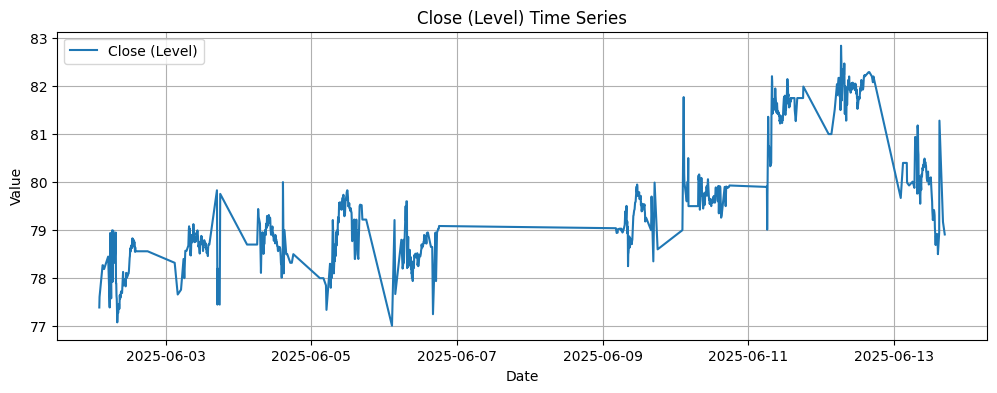


ADF Test for Close (First Difference):
ADF Statistic: -8.3892
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4369259442540416), '5%': np.float64(-2.8644432969122833), '10%': np.float64(-2.5683158550174094)}
Series is stationary



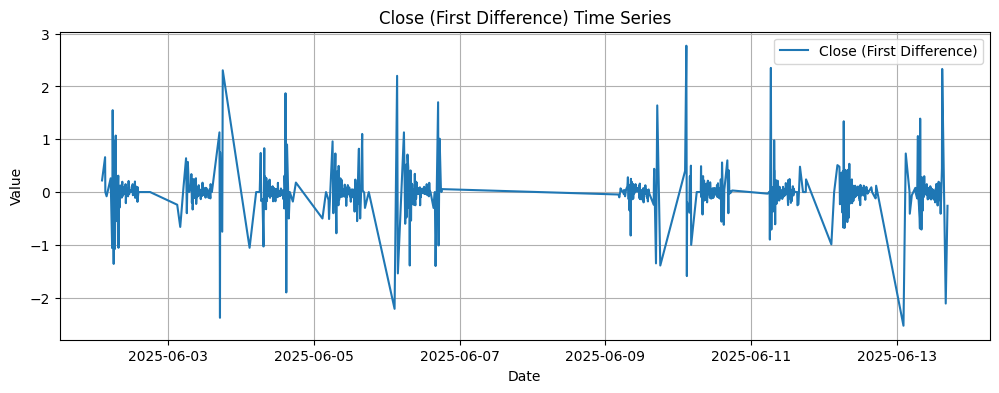

First difference is stationary, suitable for ARIMA.

Part 2: AR Model
Series is non-stationary; AR model not applied on levels.

Part 3: ARMA Model
Series is non-stationary; ARMA model not applied on levels.

Part 4: ARIMA Model
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1015
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -272.539
Date:                Sat, 14 Jun 2025   AIC                            551.078
Time:                        22:01:55   BIC                            565.843
Sample:                             0   HQIC                           556.686
                               - 1015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

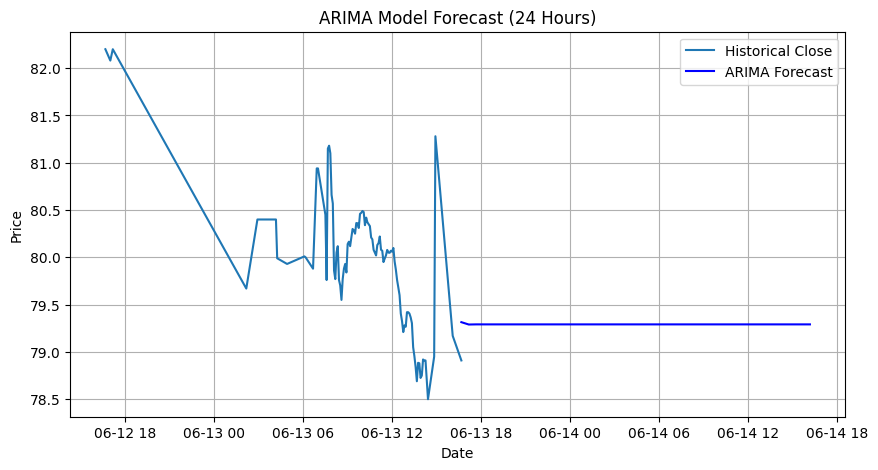


Part 5: Cointegration Analysis
No additional series specified for cointegration. Assuming univariate analysis.

Part 6: Forecasting and Trend Prediction


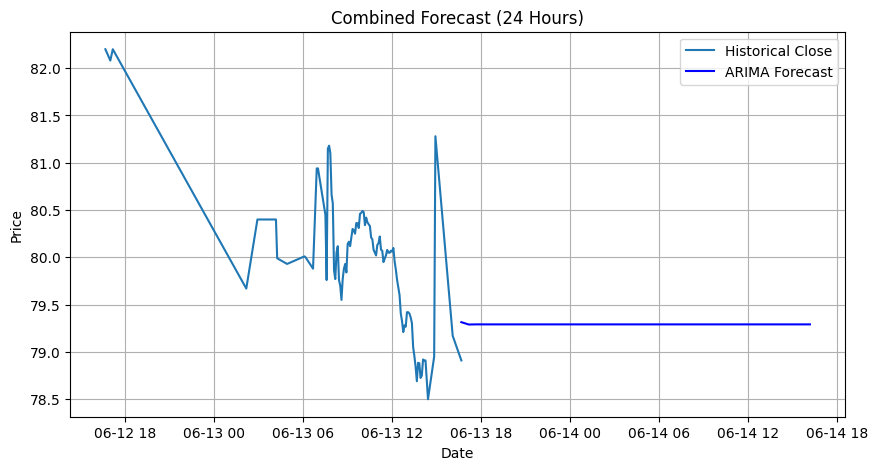

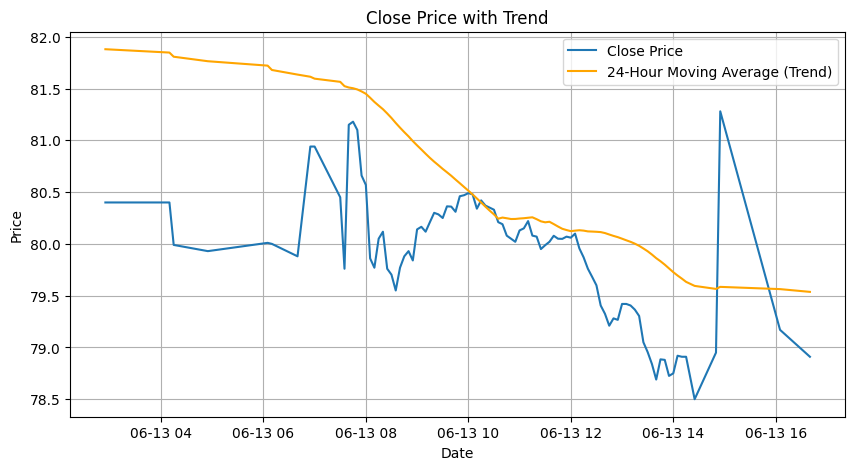


Trend Observations:
Downward trend detected over the last 24 hours.

Forecasts saved to 'tsla_close_forecasts.csv'.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# Load Data
def load_data():
    print("Please upload the Excel file '_TPS_30MINEVIDENCIA.xlsx'")
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    print(f"Uploaded file: {file_name}")

    try:
        # Skip header row
        data = pd.read_excel(file_name, skiprows=1)
        print("\nFirst 5 rows of the data:")
        print(data.head())
        print("\nColumns:", list(data.columns))
    except Exception as e:
        print(f"Error reading file: {e}")
        raise

    # Rename columns
    data = data.rename(columns={'Unnamed: 0': 'Index', 'Unnamed: 1': 'Local Date', 'Unnamed: 2': 'Close'})

    # Verify Close column
    if 'Close' not in data.columns:
        print("Error: 'Close' column not found.")
        print("Available columns:", list(data.columns))
        raise ValueError("Missing 'Close' column.")

    # Verify date column
    if 'Local Date' not in data.columns:
        print("\nWarning: 'Local Date' column not found. Generating 30-minute index.")
        data['Local Date'] = pd.date_range(start='2025-05-13 13:54:00', periods=len(data), freq='30min')

    # Parse dates
    try:
        data['Local Date'] = pd.to_datetime(data['Local Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        if data['Local Date'].isna().any():
            print("Invalid dates found. First 5 rows of Local Date:")
            print(data['Local Date'].head())
            print("\nDropping rows with invalid dates.")
            data = data.dropna(subset=['Local Date'])
        data.set_index('Local Date', inplace=True)
    except Exception as e:
        print(f"Error parsing dates: {e}")
        raise

    # Convert Close to numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    series = data['Close'].dropna()
    print("\nFirst 5 rows of Close series:")
    print(series.head())

    return series, data

# ADF Test Function with Plot
def adf_test(series, title='', plot=True):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'\nADF Test for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:', {k: v for k, v in result[4].items()})
    if result[1] < 0.05:
        print('Series is stationary\n')
    else:
        print("Series is non-stationary\n")

    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(series, label=title)
        plt.title(f'{title} Time Series')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    return result[1]

# Load data
close_series, data = load_data()

# Part 1: Stationarity Test
print("\nPart 1: Stationarity Analysis")
adf_close = adf_test(close_series, 'Close (Level)')
if adf_close > 0.05:
    adf_diff = adf_test(close_series.diff().dropna(), 'Close (First Difference)')
    if adf_diff > 0.05:
        adf_diff2 = adf_test(close_series.diff().diff().dropna(), 'Close (Second Difference)')
    else:
        print("First difference is stationary, suitable for ARIMA.")
else:
    print("Close series is stationary, suitable for AR/ARMA.")

# Part 2: AR Model
print("\nPart 2: AR Model")
ar_forecast = None
if adf_close < 0.05:
    ar_model = AutoReg(close_series, lags=1).fit()
    print(ar_model.summary())
    # Forecast 24 hours (48 steps at 30-minute intervals)
    ar_forecast = ar_model.predict(start=len(close_series), end=len(close_series)+47)
    # Plot AR forecast
    plt.figure(figsize=(10, 5))
    plt.plot(close_series[-100:], label='Historical Close')
    forecast_dates = pd.date_range(start=close_series.index[-1], periods=48, freq='30min')
    plt.plot(forecast_dates, ar_forecast, label='AR Forecast', color='red')
    plt.title('AR Model Forecast (24 Hours)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Series is non-stationary; AR model not applied on levels.")

# Part 3: ARMA Model
print("\nPart 3: ARMA Model")
arma_forecast = None
if adf_close < 0.05:
    arma_model = ARIMA(close_series, order=(1,0,1)).fit()
    print(arma_model.summary())
    arma_forecast = arma_model.forecast(steps=48)
    # Plot ARMA forecast
    plt.figure(figsize=(10, 5))
    plt.plot(close_series[-100:], label='Historical Close')
    forecast_dates = pd.date_range(start=close_series.index[-1], periods=48, freq='30min')
    plt.plot(forecast_dates, arma_forecast, label='ARMA Forecast', color='green')
    plt.title('ARMA Model Forecast (24 Hours)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Series is non-stationary; ARMA model not applied on levels.")

# Part 4: ARIMA Model
print("\nPart 4: ARIMA Model")
d = 1 if adf_close > 0.05 else 0
arima_model = ARIMA(close_series, order=(1,d,1)).fit()
print(arima_model.summary())
arima_forecast = arima_model.forecast(steps=48)
# Plot ARIMA forecast
plt.figure(figsize=(10, 5))
plt.plot(close_series[-100:], label='Historical Close')
forecast_dates = pd.date_range(start=close_series.index[-1], periods=48, freq='30min')  # Define forecast_dates
plt.plot(forecast_dates, arima_forecast, label='ARIMA Forecast', color='blue')
plt.title('ARIMA Model Forecast (24 Hours)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Part 5: Cointegration (Placeholder)
print("\nPart 5: Cointegration Analysis")
print("No additional series specified for cointegration. Assuming univariate analysis.")

# Part 6: Forecasting and Trend Prediction
print("\nPart 6: Forecasting and Trend Prediction")
# Combined forecast plot
plt.figure(figsize=(10, 5))
plt.plot(close_series[-100:], label='Historical Close')
forecast_dates = pd.date_range(start=close_series.index[-1], periods=48, freq='30min')
if ar_forecast is not None:
    plt.plot(forecast_dates, ar_forecast, label='AR Forecast', color='red')
if arma_forecast is not None:
    plt.plot(forecast_dates, arma_forecast, label='ARMA Forecast', color='green')
plt.plot(forecast_dates, arima_forecast, label='ARIMA Forecast', color='blue')
plt.title('Combined Forecast (24 Hours)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Trend prediction
trend = close_series.rolling(window=48).mean()  # 24-hour MA
plt.figure(figsize=(10, 5))
plt.plot(close_series[-96:], label='Close Price')  # Last 48 hours
plt.plot(trend[-96:], label='24-Hour Moving Average (Trend)', color='orange')
plt.title('Close Price with Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print("\nTrend Observations:")
if trend.iloc[-1] > trend.iloc[-48]:
    print("Upward trend detected over the last 24 hours.")
elif trend.iloc[-1] < trend.iloc[-48]:
    print("Downward trend detected over the last 24 hours.")
else:
    print("No clear trend detected over the last 24 hours.")

# Save forecasts to CSV
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'AR_Forecast': ar_forecast if ar_forecast is not None else np.nan,
    'ARMA_Forecast': arma_forecast if arma_forecast is not None else np.nan,
    'ARIMA_Forecast': arima_forecast
})
forecast_df.to_csv('tsla_close_forecasts.csv', index=False)
print("\nForecasts saved to 'tsla_close_forecasts.csv'.")

La serie temporal del precio de cierre de Tapestry (TPS) no es estacionaria en niveles, como lo indica el ADF Test (estadístico = –1.6083, p-valor = 0.4794). Sin embargo, al aplicar la primera diferencia, la serie se vuelve estacionaria (ADF = –8.3892, p = 0.0000), lo que la hace adecuada para modelado con ARIMA. El modelo ARIMA(1,1,1) estima un comportamiento lateral en el pronóstico de las siguientes 24 horas, con una ligera tendencia a la estabilización. No obstante, la media móvil de las últimas 24 horas muestra claramente una tendencia bajista. Esta combinación sugiere un debilitamiento progresivo del precio. Por lo tanto, la estrategia recomendada es shortear (venta en corto), anticipando una posible caída continua en el corto plazo.